# Exploratory Data Analysis: Online Retail

We plan to do some exploratory data analysis on the online retail data which we see below. Our first task would be to load the dataset.

In [11]:
# !pip install openpyxl

In [21]:
import pandas as pd
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "online_retail_II.xlsx"
df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx", engine = "openpyxl")

print(df.head())
print(df.info())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       -----------

In [22]:
print(df.shape)
print(df.columns)
# df.info()
df.isnull().sum()

(541909, 8)
Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

# We see some CustomerIDs and Description Data are missing. Description seems easy to handle as its some text based data which we can impute with some value like "Description Not Available" or "Not Available".

# Issue is with the CustomerID column which has 135k missing values. Since we anyway won't be able to track these customers even if we impute these values, these 135k records seems not so useful to us for now. It is better we drop them.

# ~500k - ~135k = ~400k

# We still a lot of data for data to explore and analyze. Lets go ahead and analyze this!

In [23]:
print("Shape of the data before dropping empty CustomerIDs.")
print(df.shape)
df = df.dropna(subset=['CustomerID'])

print("Shape of the data after dropping empty CustomerIDs.")
print(df.shape)



df['Description'] = df['Description'].fillna("No_Description_Available")

print("Rechecking the null status after dropping an imputation:")
df.isnull().sum()
print(df.shape)

# Remove negative or zero Quantity and UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Remove duplicates
df = df.drop_duplicates()

# Reset index
df = df.reset_index(drop=True)
print("Rechecking the null status and Shape after dropping an imputation:")

print(df.shape)
# Quick check
# df.info()
# df.head()


Shape of the data before dropping empty CustomerIDs.
(541909, 8)
Shape of the data after dropping empty CustomerIDs.
(406829, 8)
Rechecking the null status after dropping an imputation:
(406829, 8)
Rechecking the null status and Shape after dropping an imputation:
(392692, 8)


In [24]:
print(df[['Quantity', 'UnitPrice']].describe())

# TotalSpend per transaction
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']
print("="*35)
print("Describing: TotalSpend")
print(df['TotalSpend'].describe())

# print(df.head())

            Quantity      UnitPrice
count  392692.000000  392692.000000
mean       13.119702       3.125914
std       180.492832      22.241836
min         1.000000       0.001000
25%         2.000000       1.250000
50%         6.000000       1.950000
75%        12.000000       3.750000
max     80995.000000    8142.750000
Describing: TotalSpend
count    392692.000000
mean         22.631500
std         311.099224
min           0.001000
25%           4.950000
50%          12.450000
75%          19.800000
max      168469.600000
Name: TotalSpend, dtype: float64


In [41]:
# !pip install seaborn

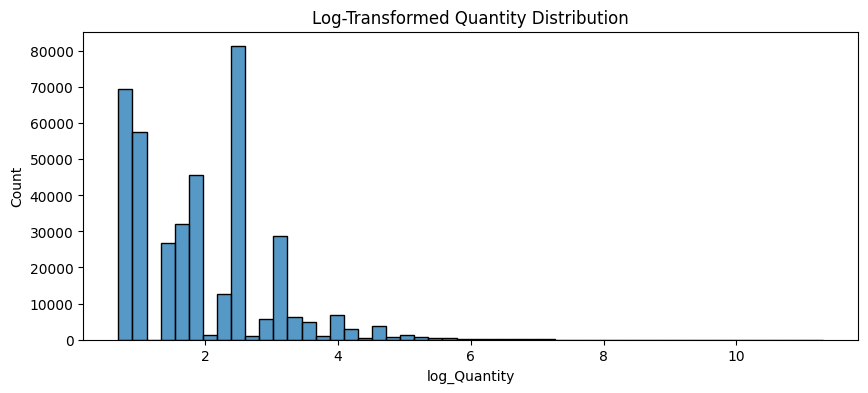

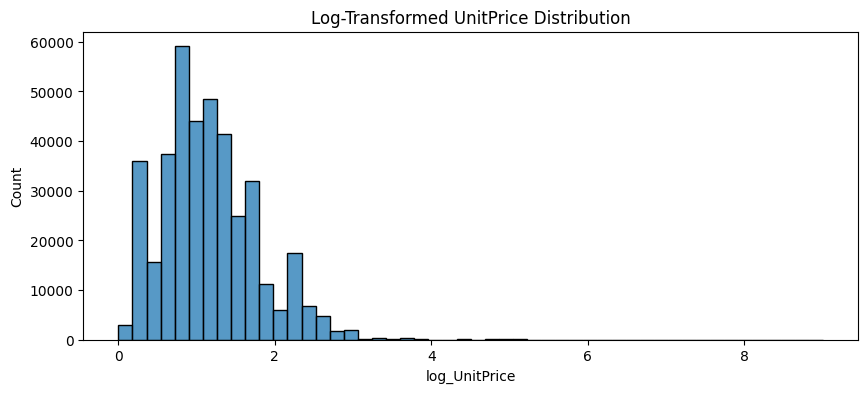

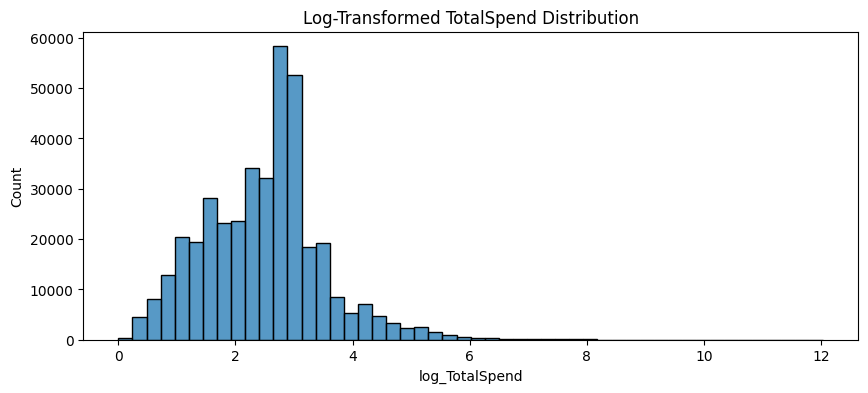

In [25]:
import numpy as np

df['log_Quantity'] = np.log1p(df['Quantity'])
df['log_UnitPrice'] = np.log1p(df['UnitPrice'])
df['log_TotalSpend'] = np.log1p(df['TotalSpend'])

import matplotlib.pyplot as plt
import seaborn as sns

# Quantity
plt.figure(figsize=(10,4))
sns.histplot(df['log_Quantity'], bins=50, kde=False)
plt.title("Log-Transformed Quantity Distribution")
plt.show()

# UnitPrice
plt.figure(figsize=(10,4))
sns.histplot(df['log_UnitPrice'], bins=50, kde=False)
plt.title("Log-Transformed UnitPrice Distribution")
plt.show()

# TotalSpend
plt.figure(figsize=(10,4))
sns.histplot(df['log_TotalSpend'], bins=50, kde=False)
plt.title("Log-Transformed TotalSpend Distribution")
plt.show()


# Above we see the distributions. Now we need to decide a threshold to call it a High Value Purchase.

In [26]:
threshold = df['TotalSpend'].quantile(0.90)
print("Threshold for HighValuePurchase:", threshold)


Threshold for HighValuePurchase: 35.400000000000006


In [27]:
# 1 = high value, 0 = normal
df['HighValuePurchase'] = (df['TotalSpend'] >= threshold).astype(int)

# Check class distribution
print(df['HighValuePurchase'].value_counts())


HighValuePurchase
0    351696
1     40996
Name: count, dtype: int64


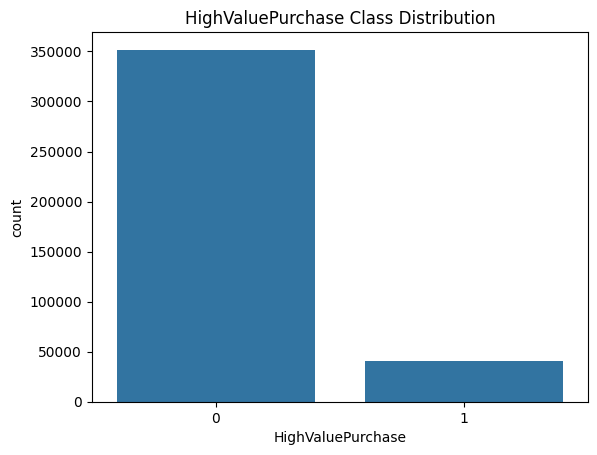

In [28]:
sns.countplot(x='HighValuePurchase', data=df)
plt.title("HighValuePurchase Class Distribution")
plt.show()


In [29]:
numeric_features = ['Quantity', 'UnitPrice', 'log_Quantity', 'log_UnitPrice']

X_numeric = df[numeric_features].copy()


X_numeric['Quantity_x_UnitPrice'] = df['Quantity'] * df['UnitPrice']

y = df['HighValuePurchase']

# One-hot encoding the Country column
X_categorical = pd.get_dummies(df['Country'], prefix='Country')

X = pd.concat([X_numeric, X_categorical], axis=1)

print("Shape of feature matrix:", X.shape)


Shape of feature matrix: (392692, 42)


# We now have enough features to start with our modelling.

In [15]:
# !pip install mlflow


In [30]:
from sklearn.model_selection import train_test_split

# Stratified split to maintain class proportions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check shapes and distribution
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test distribution:\n", y_test.value_counts(normalize=True))


X_train shape: (314153, 42)
X_test shape: (78539, 42)
y_train distribution:
 HighValuePurchase
0    0.895602
1    0.104398
Name: proportion, dtype: float64
y_test distribution:
 HighValuePurchase
0    0.895606
1    0.104394
Name: proportion, dtype: float64


# Experiment 1:

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import f1_score, confusion_matrix

import mlflow
import mlflow.sklearn

# import dagshub
# # dagshub.login()
# dagshub.init(repo_owner='Vedant321', repo_name='my-first-repo', mlflow=True)



In [32]:
# numeric_cols = ['Quantity', 'UnitPrice', 'TotalSpend', 'log_Quantity', 'log_UnitPrice', 'log_TotalSpend']


# pipeline = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000, random_state=42))])
from dagshub.auth import add_app_token

add_app_token("8716285d5baf5a5719132b91ecff49b9145457d9")

import dagshub

dagshub.init(
    repo_owner="Vedant321",
    repo_name="my-first-repo",
    mlflow=True
)


The added token already exists in the token cache, skipping


Initialized MLflow to track repo "Vedant321/my-first-repo"

Repository Vedant321/my-first-repo initialized!

In [73]:
# pipeline = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=25, random_state=42))])

# # 5-fold cross-validation F1-score
# cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
# print("Cross-validation F1-scores:", cv_scores)
# print("Mean F1-score:", cv_scores.mean())
# print("Std F1-score:", cv_scores.std())

# # Fit on full training set and evaluate on test set
# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)
# print(classification_report(y_test, y_pred))

Cross-validation F1-scores: [0.95071194 0.953863   0.95259664 0.97101449 0.9515142 ]
Mean F1-score: 0.9559400540893774
Std F1-score: 0.00761121073745352
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     70340
           1       0.98      0.93      0.96      8199

    accuracy                           0.99     78539
   macro avg       0.99      0.96      0.98     78539
weighted avg       0.99      0.99      0.99     78539



In [36]:
mlflow.set_experiment("Experiment_1_Logistic_Regression")

with mlflow.start_run(run_name="LogReg_StandardScaler"):

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ])

    cv_scores = cross_val_score(
        pipeline, X_train, y_train, cv=5, scoring="f1"
    )

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    mlflow.log_metric("cv_f1_mean", cv_scores.mean())
    mlflow.log_metric("cv_f1_std", cv_scores.std())
    mlflow.log_metric("test_f1", f1)
    mlflow.log_metric("TP", tp)
    mlflow.log_metric("TN", tn)
    mlflow.log_metric("FP", fp)
    mlflow.log_metric("FN", fn)

    mlflow.sklearn.log_model(pipeline, "model")

2025/12/16 22:49:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run LogReg_StandardScaler at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/0/runs/b8c0cae6c4f345eba0cd21eb63ce5337
🧪 View experiment at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/0


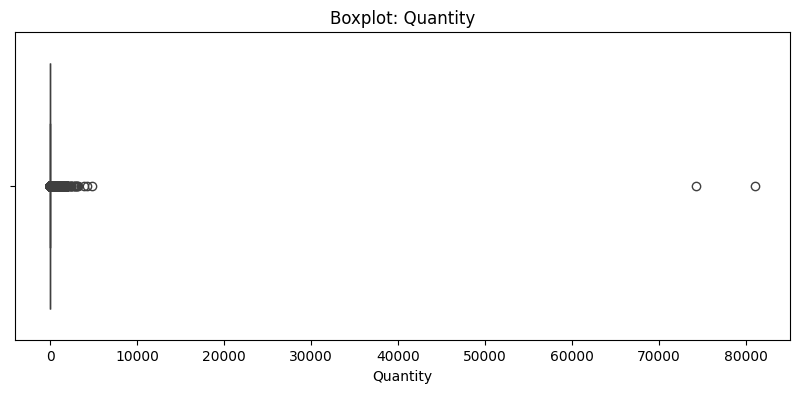

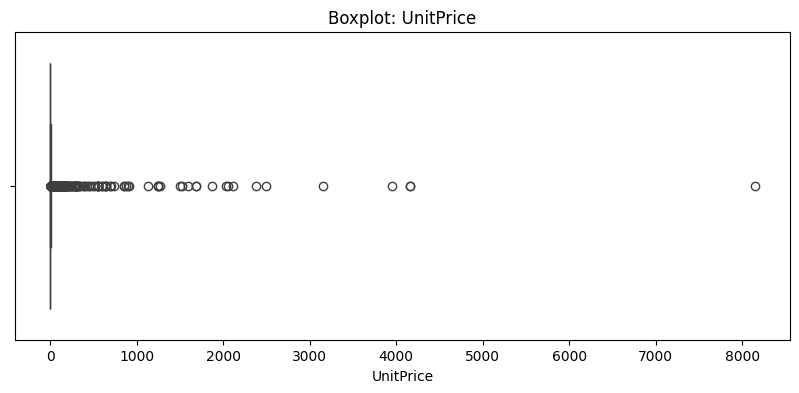

Quantity Outliers: 25616
UnitPrice Outliers: 34112


In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
sns.boxplot(x=df['Quantity'])
plt.title("Boxplot: Quantity")
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(x=df['UnitPrice'])
plt.title("Boxplot: UnitPrice")
plt.show()

Q1 = df['Quantity'].quantile(0.25)
Q3 = df['Quantity'].quantile(0.75)
IQR = Q3 - Q1
quantity_outliers = df[(df['Quantity'] < (Q1 - 1.5*IQR)) | (df['Quantity'] > (Q3 + 1.5*IQR))]

print("Quantity Outliers:", len(quantity_outliers))

P1 = df['UnitPrice'].quantile(0.25)
P3 = df['UnitPrice'].quantile(0.75)
IQR_price = P3 - P1
price_outliers = df[(df['UnitPrice'] < (P1 - 1.5*IQR_price)) | (df['UnitPrice'] > (P3 + 1.5*IQR_price))]

print("UnitPrice Outliers:", len(price_outliers))


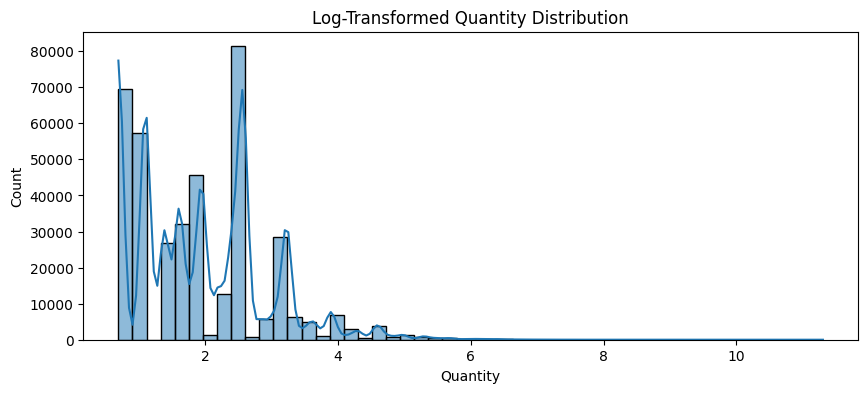

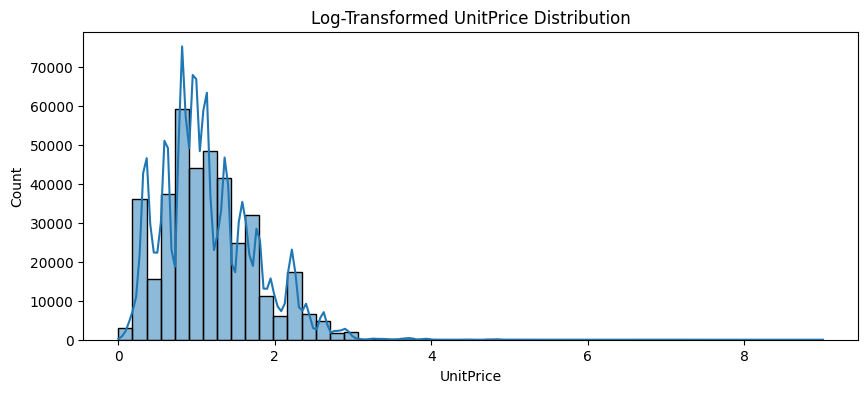

In [37]:
plt.figure(figsize=(10,4))
sns.histplot(np.log1p(df['Quantity']), bins=50, kde=True)
plt.title("Log-Transformed Quantity Distribution")
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(np.log1p(df['UnitPrice']), bins=50, kde=True)
plt.title("Log-Transformed UnitPrice Distribution")
plt.show()


In [38]:
df['log_Quantity'] = np.log1p(df['Quantity'])
df['log_UnitPrice'] = np.log1p(df['UnitPrice'])

corr_df = df[['Quantity', 'log_Quantity', 'UnitPrice', 'log_UnitPrice', 'HighValuePurchase']]

print("Correlation Matrix:")
print(corr_df.corr().to_string())


Correlation Matrix:
                   Quantity  log_Quantity  UnitPrice  log_UnitPrice  HighValuePurchase
Quantity           1.000000      0.144658  -0.004578      -0.036366           0.089720
log_Quantity       0.144658      1.000000  -0.060304      -0.405677           0.477919
UnitPrice         -0.004578     -0.060304   1.000000       0.228540           0.056344
log_UnitPrice     -0.036366     -0.405677   0.228540       1.000000           0.168775
HighValuePurchase  0.089720      0.477919   0.056344       0.168775           1.000000


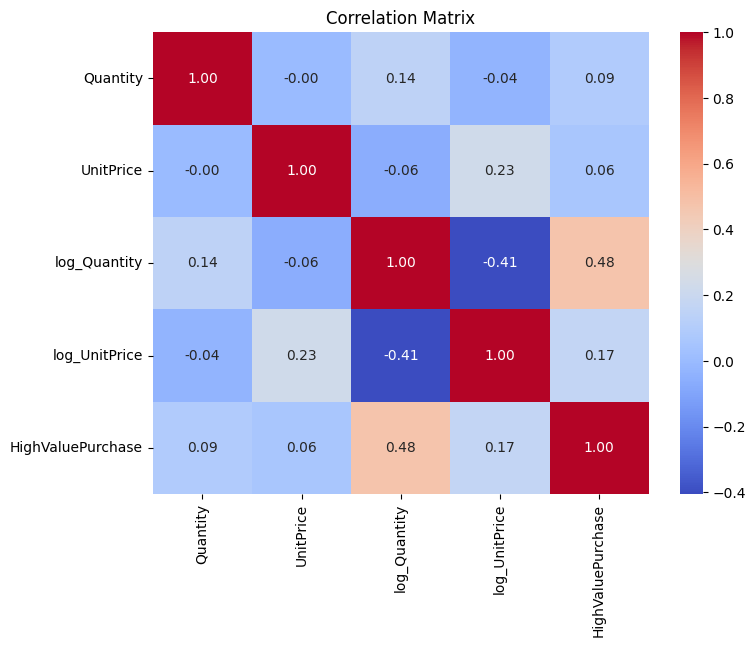

In [39]:
corr_df = pd.DataFrame({
    "Quantity": df["Quantity"],
    "UnitPrice": df["UnitPrice"],
    "log_Quantity": np.log1p(df["Quantity"]),
    "log_UnitPrice": np.log1p(df["UnitPrice"]),
    "HighValuePurchase": df["HighValuePurchase"]
})

plt.figure(figsize=(8,6))
sns.heatmap(corr_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


# Experiment 2:

In [82]:
# !pip install xgboost


In [83]:
# from sklearn.linear_model import LogisticRegression, RidgeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler

# classifiers = {
#     "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
#     "RidgeClassifier": RidgeClassifier(max_iter=1000, random_state=42),
#     "RandomForest": RandomForestClassifier(n_estimators=20, random_state=42),
#     "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# }

# for name, clf in classifiers.items():
#     pipeline = Pipeline([
#         ('scaler', StandardScaler()),
#         ('clf', clf)
#     ])
    
#     cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
#     print(f"Classifier: {name}")
#     print("  CV F1-scores:", cv_scores)
#     print("  Mean F1-score:", cv_scores.mean())
#     print("  Std F1-score:", cv_scores.std())
#     print("-"*50)


Classifier: LogisticRegression
  CV F1-scores: [0.95071194 0.953863   0.95259664 0.97101449 0.9515142 ]
  Mean F1-score: 0.9559400540893774
  Std F1-score: 0.00761121073745352
--------------------------------------------------
Classifier: RidgeClassifier
  CV F1-scores: [0.43614372 0.45047998 0.4360156  0.45391732 0.45491755]
  Mean F1-score: 0.4462948347404979
  Std F1-score: 0.008469673551928951
--------------------------------------------------
Classifier: RandomForest
  CV F1-scores: [1. 1. 1. 1. 1.]
  Mean F1-score: 1.0
  Std F1-score: 0.0
--------------------------------------------------


/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:22:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:22:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:22:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:22:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:22:46] WARNING: /worksp

Classifier: XGBoost
  CV F1-scores: [1. 1. 1. 1. 1.]
  Mean F1-score: 1.0
  Std F1-score: 0.0
--------------------------------------------------


In [40]:
import mlflow
import dagshub
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix

dagshub.init(
    repo_owner="Vedant321",
    repo_name="my-first-repo",
    mlflow=True
)

mlflow.set_experiment("Experiment_2_Model_Comparison")

classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RidgeClassifier": RidgeClassifier(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=20, random_state=42),
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    )
}

for name, clf in classifiers.items():

    with mlflow.start_run(run_name=name):

        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", clf)
        ])

        cv_scores = cross_val_score(
            pipeline, X_train, y_train, cv=5, scoring="f1"
        )

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        mlflow.log_metric("cv_f1_mean", cv_scores.mean())
        mlflow.log_metric("cv_f1_std", cv_scores.std())
        mlflow.log_metric("test_f1", f1)
        mlflow.log_metric("TP", tp)
        mlflow.log_metric("TN", tn)
        mlflow.log_metric("FP", fp)
        mlflow.log_metric("FN", fn)


        mlflow.log_param("model", name)

        mlflow.sklearn.log_model(pipeline, "model")

Initialized MLflow to track repo "Vedant321/my-first-repo"

Repository Vedant321/my-first-repo initialized!

2025/12/16 22:53:52 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_2_Model_Comparison' does not exist. Creating a new experiment.
2025/12/16 22:54:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run LogisticRegression at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/1/runs/b73d8f19cfa5458aaea113a203010b72
🧪 View experiment at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/1


2025/12/16 22:54:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run RidgeClassifier at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/1/runs/0435fba5b41a4a8698c6ab6c3f2b2324
🧪 View experiment at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/1


2025/12/16 22:55:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run RandomForest at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/1/runs/573fae47ca634863bee42d712f9a5e26
🧪 View experiment at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/1


/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:55:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:55:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:55:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:55:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:55:45] WARNING: /worksp

🏃 View run XGBoost at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/1/runs/dbd98400a2d4400b96dfb1bfd0c18208
🧪 View experiment at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/1


In [84]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

rf_scores = cross_val_score(rf, X, y, cv=cv, scoring='f1')
print("RandomForest CV F1-scores:", rf_scores)
print("Mean F1-score:", rf_scores.mean())
print("Std F1-score:", rf_scores.std())

xgb = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_scores = cross_val_score(xgb, X, y, cv=cv, scoring='f1')
print("XGBoost CV F1-scores:", xgb_scores)
print("Mean F1-score:", xgb_scores.mean())
print("Std F1-score:", xgb_scores.std())


RandomForest CV F1-scores: [0.99993902 1.         1.         1.         1.        ]
Mean F1-score: 0.9999878041343984
Std F1-score: 2.439173120314386e-05


/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:26:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:26:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:26:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:26:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:26:15] WARNING: /worksp

XGBoost CV F1-scores: [1. 1. 1. 1. 1.]
Mean F1-score: 1.0
Std F1-score: 0.0


In [41]:
import mlflow
import dagshub
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

dagshub.init(
    repo_owner="Vedant321",
    repo_name="my-first-repo",
    mlflow=True
)

mlflow.set_experiment("Experiment_6_Custom_Tuned_Models")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "RandomForest_Tuned": RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    ),
    "XGBoost_Tuned": XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    )
}

for name, model in models.items():

    with mlflow.start_run(run_name=name):

        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", model)
        ])

        cv_scores = cross_val_score(
            pipeline, X_train, y_train, cv=cv, scoring="f1"
        )

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        mlflow.log_metric("cv_f1_mean", cv_scores.mean())
        mlflow.log_metric("cv_f1_std", cv_scores.std())
        mlflow.log_metric("test_f1", f1)

        mlflow.log_metric("TP", tp)
        mlflow.log_metric("TN", tn)
        mlflow.log_metric("FP", fp)
        mlflow.log_metric("FN", fn)

        mlflow.log_param("model", name)

        mlflow.sklearn.log_model(pipeline, "model")


Initialized MLflow to track repo "Vedant321/my-first-repo"

Repository Vedant321/my-first-repo initialized!

2025/12/16 22:59:40 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_6_Custom_Tuned_Models' does not exist. Creating a new experiment.
2025/12/16 23:00:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run RandomForest_Tuned at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/2/runs/d3edb05cdfb94ced915cb84eaaf51d3e
🧪 View experiment at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/2


/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:00:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:00:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:00:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:00:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:00:38] WARNING: /worksp

🏃 View run XGBoost_Tuned at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/2/runs/d4f53ae8cc184b6690cf53e71d175df9
🧪 View experiment at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/2


# Feature Engineering

In [42]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'UnitPrice': 'mean',
})

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Quantity': 'Monetary',
    'UnitPrice': 'AvgUnitPrice'
}, inplace=True)

df['TotalSpend'] = df['Quantity'] * df['UnitPrice']
monetary = df.groupby('CustomerID')['TotalSpend'].sum().rename('MonetaryValue')
rfm = rfm.merge(monetary, left_index=True, right_index=True)


In [43]:
rfm['AvgBasketValue'] = rfm['MonetaryValue'] / rfm['Frequency']


In [44]:
high_value = df.groupby('CustomerID')['HighValuePurchase'].max().rename('HighValueCustomer')

rfm = rfm.merge(high_value, left_index=True, right_index=True)
print(rfm.head())


            Recency  Frequency  Monetary  AvgUnitPrice  MonetaryValue  \
CustomerID                                                              
12346.0         326          1     74215      1.040000       77183.60   
12347.0           2          7      2458      2.644011        4310.00   
12348.0          75          4      2341      5.764839        1797.24   
12349.0          19          1       631      8.289041        1757.55   
12350.0         310          1       197      3.841176         334.40   

            AvgBasketValue  HighValueCustomer  
CustomerID                                     
12346.0       77183.600000                  1  
12347.0         615.714286                  1  
12348.0         449.310000                  1  
12349.0        1757.550000                  1  
12350.0         334.400000                  1  


In [45]:
# Features
X = rfm[['Recency', 'Frequency', 'Monetary', 'AvgUnitPrice', 'MonetaryValue', 'AvgBasketValue']]

y = rfm['HighValueCustomer']


In [46]:
import numpy as np

X['log_Recency'] = np.log1p(X['Recency'])
X['log_Monetary'] = np.log1p(X['Monetary'])
X['log_MonetaryValue'] = np.log1p(X['MonetaryValue'])
X['log_AvgBasketValue'] = np.log1p(X['AvgBasketValue'])


In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [95]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_val_score, StratifiedKFold

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('clf', LogisticRegression(max_iter=1000, random_state=42))
# ])

# cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
# print("CV F1-scores:", cv_scores)
# print("Mean F1-score:", cv_scores.mean())
# print("Std F1-score:", cv_scores.std())

# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)

# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred))


CV F1-scores: [0.84705882 0.85400659 0.87404162 0.84491979 0.85022026]
Mean F1-score: 0.8540494162282934
Std F1-score: 0.010455343363257891
              precision    recall  f1-score   support

           0       0.65      0.46      0.54       366
           1       0.81      0.90      0.86       936

    accuracy                           0.78      1302
   macro avg       0.73      0.68      0.70      1302
weighted avg       0.77      0.78      0.77      1302



In [48]:
import mlflow
import dagshub
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, classification_report

dagshub.init(
    repo_owner="Vedant321",
    repo_name="my-first-repo",
    mlflow=True
)

mlflow.set_experiment("Experiment_1_Logistic_Regression")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

with mlflow.start_run(run_name="LogReg_StratifiedCV"):

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ])

    cv_scores = cross_val_score(
        pipeline, X_train, y_train, cv=cv, scoring="f1"
    )

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    mlflow.log_metric("cv_f1_mean", cv_scores.mean())
    mlflow.log_metric("cv_f1_std", cv_scores.std())
    mlflow.log_metric("test_f1", f1)

    mlflow.log_metric("TP", tp)
    mlflow.log_metric("TN", tn)
    mlflow.log_metric("FP", fp)
    mlflow.log_metric("FN", fn)

    mlflow.log_param("cv_strategy", "StratifiedKFold")
    mlflow.log_param("model", "LogisticRegression")

    mlflow.sklearn.log_model(pipeline, "model")


Initialized MLflow to track repo "Vedant321/my-first-repo"

Repository Vedant321/my-first-repo initialized!

2025/12/16 23:07:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run LogReg_StratifiedCV at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/0/runs/c73b94ed3dad468f931b5846f1001270
🧪 View experiment at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/0


In [50]:
df_rfm = df.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (df['InvoiceDate'].max() - x.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('Quantity', lambda x: (x * df.loc[x.index, 'UnitPrice']).sum())
)

df_rfm['AvgUnitPrice'] = df.groupby('CustomerID')['UnitPrice'].mean()
df_rfm['MonetaryValue'] = df.groupby('CustomerID').apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum())
df_rfm['AvgBasketValue'] = df_rfm['MonetaryValue'] / df_rfm['Frequency']


df_rfm['HighValueCustomer'] = (df_rfm['MonetaryValue'] > df_rfm['MonetaryValue'].quantile(0.9)).astype(int)


df_rfm = df_rfm.reset_index()


/tmp/ipykernel_44/1796033572.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rfm['MonetaryValue'] = df.groupby('CustomerID').apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum())


In [51]:
rfm_features = ['Recency', 'Frequency', 'Monetary', 'AvgUnitPrice', 'MonetaryValue', 'AvgBasketValue']
X_rfm = df_rfm[rfm_features]
y_rfm = df_rfm['HighValueCustomer']


In [100]:
# from sklearn.model_selection import StratifiedKFold, cross_val_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# import numpy as np

# rfm_features = ['Recency', 'Frequency', 'Monetary', 'AvgUnitPrice', 'MonetaryValue', 'AvgBasketValue']
# X_rfm = df_rfm[rfm_features]
# y_rfm = df_rfm['HighValueCustomer']

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# lr = LogisticRegression(max_iter=1000, random_state=42)
# lr_scores = cross_val_score(lr, X_rfm, y_rfm, cv=cv, scoring='f1')
# print("LogisticRegression CV F1-scores:", lr_scores)
# print("Mean F1-score:", lr_scores.mean())
# print("Std F1-score:", lr_scores.std())
# print("--------------------------------------------------")

# rf = RandomForestClassifier(
#     n_estimators=100,
#     max_depth=5,
#     min_samples_split=10,
#     min_samples_leaf=5,
#     random_state=42
# )
# rf_scores = cross_val_score(rf, X_rfm, y_rfm, cv=cv, scoring='f1')
# print("RandomForest CV F1-scores:", rf_scores)
# print("Mean F1-score:", rf_scores.mean())
# print("Std F1-score:", rf_scores.std())
# print("--------------------------------------------------")

# xgb = XGBClassifier(
#     n_estimators=100,
#     max_depth=3,
#     learning_rate=0.1,
#     min_child_weight=5,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     use_label_encoder=False,
#     eval_metric='logloss',
#     random_state=42
# )
# xgb_scores = cross_val_score(xgb, X_rfm, y_rfm, cv=cv, scoring='f1')
# print("XGBoost CV F1-scores:", xgb_scores)
# print("Mean F1-score:", xgb_scores.mean())
# print("Std F1-score:", xgb_scores.std())


LogisticRegression CV F1-scores: [0.99421965 1.         1.         1.         0.99421965]
Mean F1-score: 0.9976878612716764
Std F1-score: 0.002831780049460347
--------------------------------------------------
RandomForest CV F1-scores: [1.         1.         0.99428571 1.         1.        ]
Mean F1-score: 0.9988571428571429
Std F1-score: 0.0022857142857142685
--------------------------------------------------


/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:34:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:34:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost CV F1-scores: [0.98265896 0.98245614 0.98305085 1.         0.99421965]
Mean F1-score: 0.9884771201050535
Std F1-score: 0.007284244252004802


/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:34:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:34:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:34:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [52]:
import mlflow
import dagshub
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix

dagshub.init(
    repo_owner="Vedant321",
    repo_name="my-first-repo",
    mlflow=True
)

mlflow.set_experiment("Experiment_3_Feature_Engineering_RFM")

rfm_features = [
    'Recency', 'Frequency', 'Monetary',
    'AvgUnitPrice', 'MonetaryValue', 'AvgBasketValue'
]

X = df_rfm[rfm_features]
y = df_rfm['HighValueCustomer']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=100, max_depth=5,
        min_samples_split=10, min_samples_leaf=5,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100, max_depth=3,
        learning_rate=0.1, min_child_weight=5,
        subsample=0.8, colsample_bytree=0.8,
        use_label_encoder=False, eval_metric="logloss",
        random_state=42
    )
}

for name, model in models.items():

    with mlflow.start_run(run_name=name):

        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", model)
        ])

        cv_scores = cross_val_score(
            pipeline, X_train, y_train, cv=cv, scoring="f1"
        )

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        mlflow.log_param("feature_set", "RFM_only")
        mlflow.log_param("model", name)

        mlflow.log_metric("cv_f1_mean", cv_scores.mean())
        mlflow.log_metric("cv_f1_std", cv_scores.std())
        mlflow.log_metric("test_f1", f1)

        mlflow.log_metric("TP", tp)
        mlflow.log_metric("TN", tn)
        mlflow.log_metric("FP", fp)
        mlflow.log_metric("FN", fn)

        mlflow.sklearn.log_model(pipeline, "model")


Initialized MLflow to track repo "Vedant321/my-first-repo"

Repository Vedant321/my-first-repo initialized!

2025/12/16 23:10:57 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_3_Feature_Engineering_RFM' does not exist. Creating a new experiment.
2025/12/16 23:10:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run LogisticRegression at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/3/runs/13eca526a3104b69a065debf269e7211
🧪 View experiment at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/3


2025/12/16 23:11:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run RandomForest at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/3/runs/1ba4b2820c954700b407289ff042ce6f
🧪 View experiment at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/3


/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:11:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:11:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:11:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:11:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:11:52] WARNING: /worksp

🏃 View run XGBoost at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/3/runs/3a8b7a27086344268280bdb475320838
🧪 View experiment at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/3


# Feature Selection:

Correlation Matrix:
                 Recency  Frequency  Monetary  AvgUnitPrice  MonetaryValue  \
Recency         1.000000  -0.260578 -0.121831      0.017353      -0.121831   
Frequency      -0.260578   1.000000  0.552780     -0.010771       0.552780   
Monetary       -0.121831   0.552780  1.000000      0.013402       1.000000   
AvgUnitPrice    0.017353  -0.010771  0.013402      1.000000       0.013402   
MonetaryValue  -0.121831   0.552780  1.000000      0.013402       1.000000   
AvgBasketValue -0.000115   0.019130  0.393667      0.035649       0.393667   

                AvgBasketValue  
Recency              -0.000115  
Frequency             0.019130  
Monetary              0.393667  
AvgUnitPrice          0.035649  
MonetaryValue         0.393667  
AvgBasketValue        1.000000  


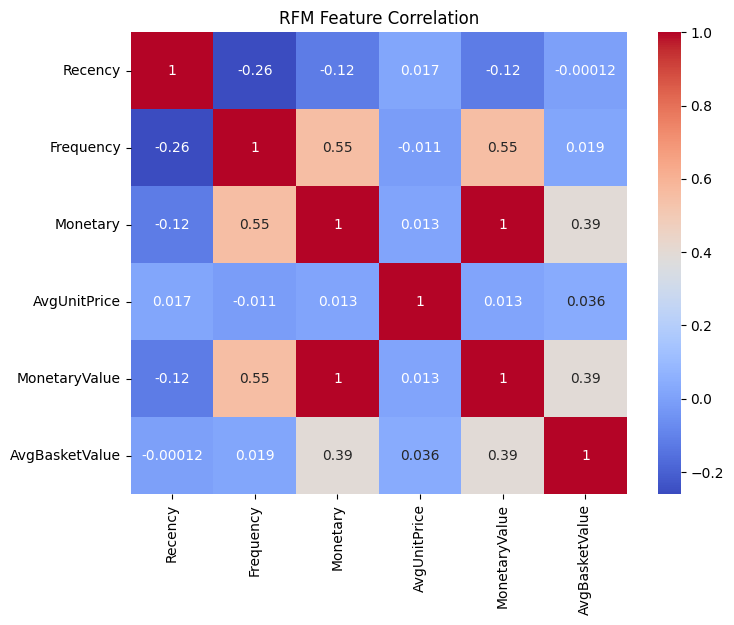

Features to drop due to high correlation: ['MonetaryValue']

Feature importances:
Monetary          0.721155
Frequency         0.188786
AvgBasketValue    0.066174
Recency           0.021072
AvgUnitPrice      0.002812
dtype: float64


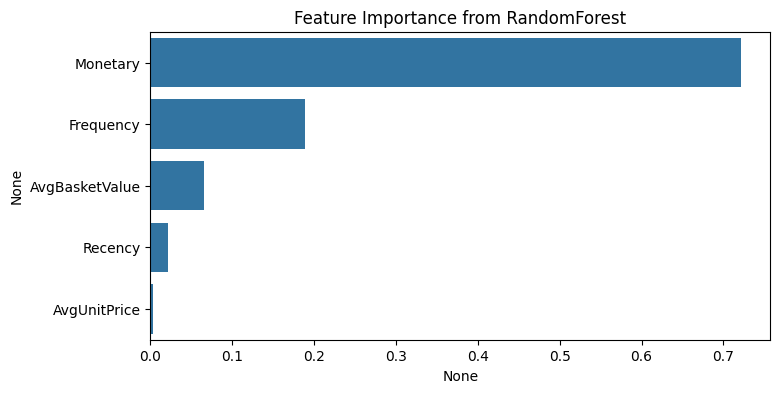

In [53]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

rfm_features = ['Recency', 'Frequency', 'Monetary', 'AvgUnitPrice', 'MonetaryValue', 'AvgBasketValue']
corr_matrix = df_rfm[rfm_features].corr()

print("Correlation Matrix:")
print(corr_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("RFM Feature Correlation")
plt.show()

upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(abs(upper_tri[column]) > 0.9)]
print("Features to drop due to high correlation:", to_drop)

X_selected = df_rfm[rfm_features].drop(columns=to_drop)
y = df_rfm['HighValueCustomer']

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_selected, y)

importances = pd.Series(rf.feature_importances_, index=X_selected.columns).sort_values(ascending=False)
print("\nFeature importances:")
print(importances)

plt.figure(figsize=(8,4))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance from RandomForest")
plt.show()


In [102]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from sklearn.model_selection import cross_val_score, StratifiedKFold
# import numpy as np

# X_selected = df_rfm[['Monetary', 'Frequency', 'AvgBasketValue', 'Recency', 'AvgUnitPrice']]
# y = df_rfm['HighValueCustomer']

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# lr = LogisticRegression(max_iter=1000, random_state=42)
# lr_scores = cross_val_score(lr, X_selected, y, cv=cv, scoring='f1')
# print("LogisticRegression CV F1-scores:", lr_scores)
# print("Mean F1-score:", lr_scores.mean())
# print("Std F1-score:", lr_scores.std())

# rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
# rf_scores = cross_val_score(rf, X_selected, y, cv=cv, scoring='f1')
# print("\nRandomForest CV F1-scores:", rf_scores)
# print("Mean F1-score:", rf_scores.mean())
# print("Std F1-score:", rf_scores.std())

# xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1,
#                     min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
#                     use_label_encoder=False, eval_metric='logloss', random_state=42)
# xgb_scores = cross_val_score(xgb, X_selected, y, cv=cv, scoring='f1')
# print("\nXGBoost CV F1-scores:", xgb_scores)
# print("Mean F1-score:", xgb_scores.mean())
# print("Std F1-score:", xgb_scores.std())


LogisticRegression CV F1-scores: [0.99421965 1.         1.         1.         0.99421965]
Mean F1-score: 0.9976878612716764
Std F1-score: 0.002831780049460347

RandomForest CV F1-scores: [1.         1.         0.99428571 1.         1.        ]
Mean F1-score: 0.9988571428571429
Std F1-score: 0.0022857142857142685

XGBoost CV F1-scores: [0.98265896 0.99421965 0.99428571 1.         1.        ]
Mean F1-score: 0.9942328654004953
Std F1-score: 0.006332107823922057


/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:39:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:39:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:39:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:39:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:39:22] WARNING: /worksp

In [54]:
import mlflow
import dagshub
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix

dagshub.init(
    repo_owner="Vedant321",
    repo_name="my-first-repo",
    mlflow=True
)

mlflow.set_experiment("Experiment_4_Feature_Selection")

selected_features = [
    'Monetary',
    'Frequency',
    'AvgBasketValue',
    'Recency',
    'AvgUnitPrice'
]

X = df_rfm[selected_features]
y = df_rfm['HighValueCustomer']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=200, max_depth=5, random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100, max_depth=3, learning_rate=0.1,
        min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
        use_label_encoder=False, eval_metric="logloss",
        random_state=42
    )
}

for name, model in models.items():

    with mlflow.start_run(run_name=name):

        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", model)
        ])

        cv_scores = cross_val_score(
            pipeline, X_train, y_train, cv=cv, scoring="f1"
        )

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        mlflow.log_param("feature_selection_method", "manual + importance")
        mlflow.log_param("selected_features", ",".join(selected_features))
        mlflow.log_param("model", name)

        mlflow.log_metric("cv_f1_mean", cv_scores.mean())
        mlflow.log_metric("cv_f1_std", cv_scores.std())
        mlflow.log_metric("test_f1", f1)

        mlflow.log_metric("TP", tp)
        mlflow.log_metric("TN", tn)
        mlflow.log_metric("FP", fp)
        mlflow.log_metric("FN", fn)

        mlflow.sklearn.log_model(pipeline, "model")


Initialized MLflow to track repo "Vedant321/my-first-repo"

Repository Vedant321/my-first-repo initialized!

2025/12/16 23:14:04 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_4_Feature_Selection' does not exist. Creating a new experiment.
2025/12/16 23:14:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run LogisticRegression at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/4/runs/94678726f883426c910fa921427e60f1
🧪 View experiment at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/4


2025/12/16 23:14:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run RandomForest at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/4/runs/17d667e68eae49bd953de62a2c16f7f5
🧪 View experiment at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/4


/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:15:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:15:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:15:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:15:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:15:01] WARNING: /worksp

🏃 View run XGBoost at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/4/runs/c6362a1fc3584a32942fa88e41fd1a40
🧪 View experiment at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/4


# PCA:

In [103]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_selected)

# pca = PCA(n_components=0.95)
# X_pca = pca.fit_transform(X_scaled)

# print("Original shape:", X_selected.shape)
# print("Transformed shape after PCA:", X_pca.shape)
# print("Explained variance ratio per component:", pca.explained_variance_ratio_)
# print("Total variance explained:", np.sum(pca.explained_variance_ratio_))


Original shape: (4338, 5)
Transformed shape after PCA: (4338, 5)
Explained variance ratio per component: [0.35277515 0.22343251 0.1970646  0.16200418 0.06472356]
Total variance explained: 1.0


In [104]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from sklearn.model_selection import StratifiedKFold, cross_val_score



# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# lr = LogisticRegression(max_iter=1000, random_state=42)
# lr_scores = cross_val_score(lr, X_pca, y_rfm, cv=cv, scoring='f1')
# print("LogisticRegression CV F1-scores:", lr_scores)
# print("Mean F1-score:", lr_scores.mean())
# print("Std F1-score:", lr_scores.std())
# print("-"*50)

# rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10, 
#                             min_samples_leaf=5, random_state=42)
# rf_scores = cross_val_score(rf, X_pca, y_rfm, cv=cv, scoring='f1')
# print("RandomForest CV F1-scores:", rf_scores)
# print("Mean F1-score:", rf_scores.mean())
# print("Std F1-score:", rf_scores.std())
# print("-"*50)

# xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1,
#                     min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
#                     use_label_encoder=False, eval_metric='logloss', random_state=42)
# xgb_scores = cross_val_score(xgb, X_pca, y_rfm, cv=cv, scoring='f1')
# print("XGBoost CV F1-scores:", xgb_scores)
# print("Mean F1-score:", xgb_scores.mean())
# print("Std F1-score:", xgb_scores.std())


LogisticRegression CV F1-scores: [0.90909091 0.84810127 0.89570552 0.92857143 0.925     ]
Mean F1-score: 0.9012938249915029
Std F1-score: 0.02907755972632353
--------------------------------------------------
RandomForest CV F1-scores: [0.91666667 0.86419753 0.89940828 0.94117647 0.89570552]
Mean F1-score: 0.9034308947230322
Std F1-score: 0.025357577899790627
--------------------------------------------------


/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:41:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:41:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:41:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:41:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [01:41:41] WARNING: /worksp

XGBoost CV F1-scores: [0.95294118 0.9047619  0.94252874 0.95953757 0.90361446]
Mean F1-score: 0.9326767693900674
Std F1-score: 0.023887518849892975


In [55]:

import dagshub
import mlflow
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score



dagshub.init(
    repo_owner="Vedant321",
    repo_name="my-first-repo",
    mlflow=True
)

mlflow.set_experiment("Experiment_5_PCA")



X = X_selected
y = y_rfm

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    )
}


for model_name, clf in models.items():

    with mlflow.start_run(run_name=f"{model_name}_PCA"):

        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("pca", PCA(n_components=0.95)),
            ("clf", clf)
        ])

        cv_scores = cross_val_score(
            pipeline,
            X,
            y,
            cv=cv,
            scoring="f1"
        )

        mlflow.log_param("model", model_name)
        mlflow.log_param("pca_variance_retained", 0.95)

        mlflow.log_metric("cv_f1_mean", cv_scores.mean())
        mlflow.log_metric("cv_f1_std", cv_scores.std())

        print(f"Model: {model_name}")
        print("CV F1-scores:", cv_scores)
        print("Mean F1-score:", cv_scores.mean())
        print("Std F1-score:", cv_scores.std())
        print("-" * 60)


Initialized MLflow to track repo "Vedant321/my-first-repo"

Repository Vedant321/my-first-repo initialized!

2025/12/16 23:19:18 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_5_PCA' does not exist. Creating a new experiment.


Model: LogisticRegression
CV F1-scores: [0.90909091 0.86956522 0.88198758 0.92857143 0.91823899]
Mean F1-score: 0.9014908252808171
Std F1-score: 0.022231700798288026
------------------------------------------------------------
🏃 View run LogisticRegression_PCA at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/5/runs/27d61cf81dfb4de1a6153fcbf748046c
🧪 View experiment at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/5
Model: RandomForest
CV F1-scores: [0.90361446 0.85542169 0.85889571 0.95348837 0.86956522]
Mean F1-score: 0.8881970879168227
Std F1-score: 0.03682551185213811
------------------------------------------------------------
🏃 View run RandomForest_PCA at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/5/runs/97e69204237547e0ad09ea5401b0c4e6
🧪 View experiment at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/5


/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:19:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:19:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:19:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:19:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:19:26] WARNING: /worksp

Model: XGBoost
CV F1-scores: [0.93333333 0.88888889 0.94915254 0.95348837 0.9047619 ]
Mean F1-score: 0.9259250082900063
Std F1-score: 0.025194014110066502
------------------------------------------------------------
🏃 View run XGBoost_PCA at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/5/runs/a4d9a0f04324440580c22f61468fd422
🧪 View experiment at: https://dagshub.com/Vedant321/my-first-repo.mlflow/#/experiments/5


In [56]:
# import pandas as pd

# experiment_summary = [
#     {"Experiment": "Original numeric features", "Model": "LogisticRegression", "Mean_F1": 0.9559, "Std_F1": 0.0076},
#     {"Experiment": "Original numeric features", "Model": "RandomForest", "Mean_F1": 1.0, "Std_F1": 0.0},
#     {"Experiment": "Original numeric features", "Model": "XGBoost", "Mean_F1": 1.0, "Std_F1": 0.0},
#     {"Experiment": "RFM features", "Model": "LogisticRegression", "Mean_F1": 0.9977, "Std_F1": 0.0028},
#     {"Experiment": "RFM features", "Model": "RandomForest", "Mean_F1": 0.9989, "Std_F1": 0.0023},
#     {"Experiment": "RFM features", "Model": "XGBoost", "Mean_F1": 0.9942, "Std_F1": 0.0063},
#     {"Experiment": "RFM after PCA", "Model": "LogisticRegression", "Mean_F1": 0.9013, "Std_F1": 0.0291},
#     {"Experiment": "RFM after PCA", "Model": "RandomForest", "Mean_F1": 0.9034, "Std_F1": 0.0254},
#     {"Experiment": "RFM after PCA", "Model": "XGBoost", "Mean_F1": 0.9327, "Std_F1": 0.0239},
# ]

# # Convert to DataFrame
# summary_df = pd.DataFrame(experiment_summary)

# # Sort by Mean_F1 descending
# summary_df = summary_df.sort_values(by="Mean_F1", ascending=False).reset_index(drop=True)

# print(summary_df)


                  Experiment               Model  Mean_F1  Std_F1
0  Original numeric features        RandomForest   1.0000  0.0000
1  Original numeric features             XGBoost   1.0000  0.0000
2               RFM features        RandomForest   0.9989  0.0023
3               RFM features  LogisticRegression   0.9977  0.0028
4               RFM features             XGBoost   0.9942  0.0063
5  Original numeric features  LogisticRegression   0.9559  0.0076
6              RFM after PCA             XGBoost   0.9327  0.0239
7              RFM after PCA        RandomForest   0.9034  0.0254
8              RFM after PCA  LogisticRegression   0.9013  0.0291


In [57]:
import pandas as pd

experiment_summary = [
    {
        "Experiment_ID": "Exp_1",
        "Feature_Set": "Original_Numeric_Features",
        "Model": "LogisticRegression",
        "CV_F1_Mean": 0.9559,
        "CV_F1_Std": 0.0076
    },
    {
        "Experiment_ID": "Exp_1",
        "Feature_Set": "Original_Numeric_Features",
        "Model": "RandomForest",
        "CV_F1_Mean": 1.0000,
        "CV_F1_Std": 0.0000
    },
    {
        "Experiment_ID": "Exp_1",
        "Feature_Set": "Original_Numeric_Features",
        "Model": "XGBoost",
        "CV_F1_Mean": 1.0000,
        "CV_F1_Std": 0.0000
    },
    {
        "Experiment_ID": "Exp_3",
        "Feature_Set": "RFM_Features",
        "Model": "LogisticRegression",
        "CV_F1_Mean": 0.9977,
        "CV_F1_Std": 0.0028
    },
    {
        "Experiment_ID": "Exp_3",
        "Feature_Set": "RFM_Features",
        "Model": "RandomForest",
        "CV_F1_Mean": 0.9989,
        "CV_F1_Std": 0.0023
    },
    {
        "Experiment_ID": "Exp_3",
        "Feature_Set": "RFM_Features",
        "Model": "XGBoost",
        "CV_F1_Mean": 0.9942,
        "CV_F1_Std": 0.0063
    },
    {
        "Experiment_ID": "Exp_5",
        "Feature_Set": "RFM_PCA_95pct_Variance",
        "Model": "LogisticRegression",
        "CV_F1_Mean": 0.9013,
        "CV_F1_Std": 0.0291
    },
    {
        "Experiment_ID": "Exp_5",
        "Feature_Set": "RFM_PCA_95pct_Variance",
        "Model": "RandomForest",
        "CV_F1_Mean": 0.9034,
        "CV_F1_Std": 0.0254
    },
    {
        "Experiment_ID": "Exp_5",
        "Feature_Set": "RFM_PCA_95pct_Variance",
        "Model": "XGBoost",
        "CV_F1_Mean": 0.9327,
        "CV_F1_Std": 0.0239
    },
]

summary_df = pd.DataFrame(experiment_summary)

summary_df = summary_df.sort_values(
    by="CV_F1_Mean",
    ascending=False
).reset_index(drop=True)

summary_df


,Experiment_ID,Feature_Set,Model,CV_F1_Mean,CV_F1_Std
0,Exp_1,Original_Numeric_Features,RandomForest,1.0000,0.0000
1,Exp_1,Original_Numeric_Features,XGBoost,1.0000,0.0000
2,Exp_3,RFM_Features,RandomForest,0.9989,0.0023
3,Exp_3,RFM_Features,LogisticRegression,0.9977,0.0028
4,Exp_3,RFM_Features,XGBoost,0.9942,0.0063
5,Exp_1,Original_Numeric_Features,LogisticRegression,0.9559,0.0076
6,Exp_5,RFM_PCA_95pct_Variance,XGBoost,0.9327,0.0239
7,Exp_5,RFM_PCA_95pct_Variance,RandomForest,0.9034,0.0254
8,Exp_5,RFM_PCA_95pct_Variance,LogisticRegression,0.9013,0.0291


In [106]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    ))
])

rfm_features = ['Recency', 'Frequency', 'Monetary', 'AvgUnitPrice', 'AvgBasketValue']
X_final = df_rfm[rfm_features]
y_final = df_rfm['HighValueCustomer']

pipeline.fit(X_final, y_final)


joblib.dump(pipeline, "final_model_pipeline.pkl")
print("Pipeline saved as final_model_pipeline.pkl")


Pipeline saved as final_model_pipeline.pkl


In [ ]:
# Online Retail High-Value Customer Prediction

An end-to-end machine learning project that predicts high-value customers from Online Retail transaction data.  
The project covers the full ML lifecycle — data preprocessing, feature engineering, model training, experiment tracking, API deployment, and a Streamlit-based user interface.

---

## Project Architecture



In [ ]:
# Python
__pycache__/
*.py[cod]
*.pyo
*.pyd
*.egg-info/
dist/
build/

# Virtual environments
venv/
.env/
.venv/

# Jupyter
.ipynb_checkpoints/

# ML artifacts
mlruns/
artifacts/
*.pkl
*.joblib

# Streamlit
.streamlit/

# OS
.DS_Store
Thumbs.db

# Logs
*.log